In [1]:
import os
os.getcwd()
import sys
sys.path.append('/Users/juncheng/PycharmProjects/test')
import matplotlib.pyplot as mpl
import numpy as np
import modelBuilder
import models
import time
import jax

In [2]:


def RunModel(ParamArray,runTime,totalRuns,t0 = time.time()):

    model = modelBuilder.ModelStructure(True,False ,False,1,ParamArray)

    with jax.default_device(jax.devices("cpu")[0]):
        jax.config.update("jax_enable_x64", True)

        # Get the maps of the equations and the parameters of the model for the solver
        states, capacitorObjects, resistorObjects, connectionbjects, dVdt, capacitors, flows, resistors, pressures = model.getEquationMaps()

        # Create the model object with the parameters and the equations to be solved by JAX
        cpModel = models.CardioPulmonaryModel(capacitorObjects, resistorObjects, connectionbjects, states)

        t1 = time.time()
        print(str(np.round(t1 - t0, 4)) + ' -> Model Initialised!')
        
        # First run to compile the model
        res, t_dense, y_dense, deriv, out = models.solveModel(cpModel,runTime,states)
        print(str(np.round(time.time() - t1, 4)) + ' -> Compiled!')
        t1 = time.time()
        

        # Second run to get the results
        pressureRes = {key: np.array([]) for key in out.keys()} 
        runsRes = {key: np.array([]) for key in y_dense.keys()} 

        for nruns in range(totalRuns):
            # Update the states with the last values of the previous run
            newStates = {key: float(y_dense[key][-1]) for key in states.keys()}

            newStates['R_Lu|0|0|0'] = 0.003 + 0.003* nruns

            # Run the model with the updated states
            res, t_dense, y_dense, deriv, out = models.solveModel(cpModel,runTime,newStates)

            # Concatenate the results of the runs to the previous results
            pressureRes = {key: np.concatenate((pressureRes[key] , np.array(value)),axis = 0) for key, value in out.items()}  
            runsRes = {key: np.concatenate((runsRes[key] , np.array(value)),axis = 0) for key, value in y_dense.items()} 

            print(str(np.round(time.time() - t1, 4)) + ' -> Run:' + str(nruns) + ' of ' + str(totalRuns-1) + ' completed!')
            t1 = time.time()

            print(pressureRes.keys())

            results = {
            'I_Lu|0': pressureRes['I_Lu|0'],
            'I_Lu|0|0': pressureRes['I_Lu|0|0'], 
            'I_Lu|0|0|0': pressureRes['I_Lu|0|0|0']
            }

        return results




In [7]:

# a change
t0 = time.time()
# initialiseModel(lung,heart,gasExchange,nrLevels)
# lung,heart,gasExchange  --> True or False to enable the parts of the model
# nrLevels                --> 1 (Basic Model) or 2 or 5 (trees with 2 or 5 generations)

runTime = 3.0
totalRuns = 1
totalTime = runTime*totalRuns

# Create the time vector
t = np.arange(0, totalTime + totalRuns*0.01 , 0.01)

#ParamArray = ['R_Lu|0','R_Lu|0|0', 'R_Lu|0|0|0', 'C_Lu|0', 'C_Lu|0|0', 'C_Lu|0|0|0']
ParamArray = [0.001,0.002,0.003,2.4,3,100]
# with initial conditions -> [0.001,0.002,0.003,2.4,3,100,28,36,1400]

runRes = RunModel(ParamArray,runTime,totalRuns,t0 = time.time())


Simple Lung initialised
0.0022 -> Model Initialised!
6.6597 -> Compiled!
0.0774 -> Run:0 of 0 completed!
dict_keys(['I_Lu|0', 'I_Lu|0|0', 'I_Lu|0|0|0', 'V_Lu|0', 'V_Lu|0|0', 'V_Lu|0|0|0', 'u'])


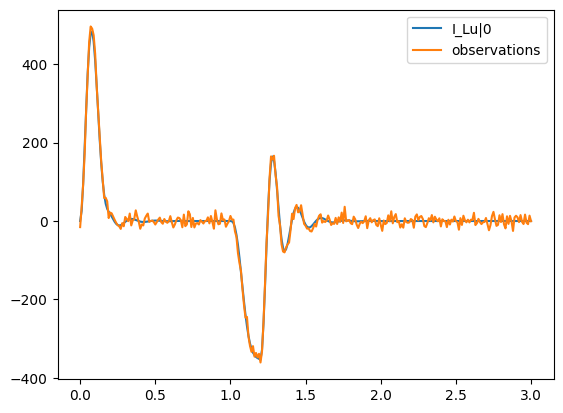

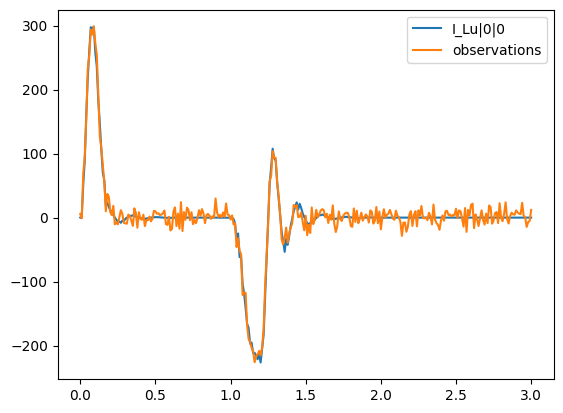

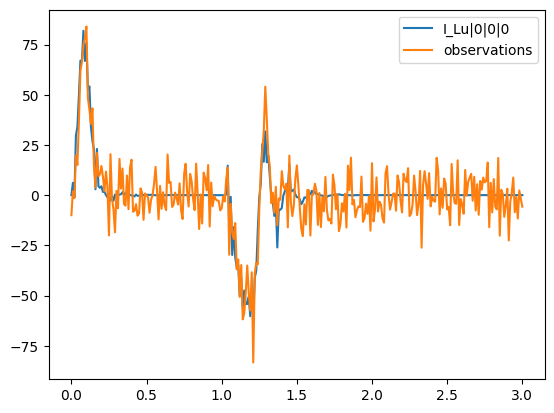

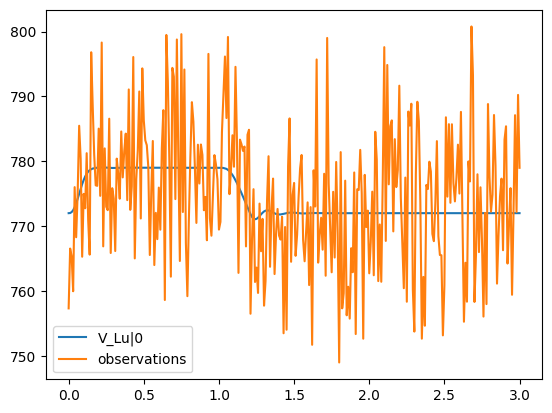

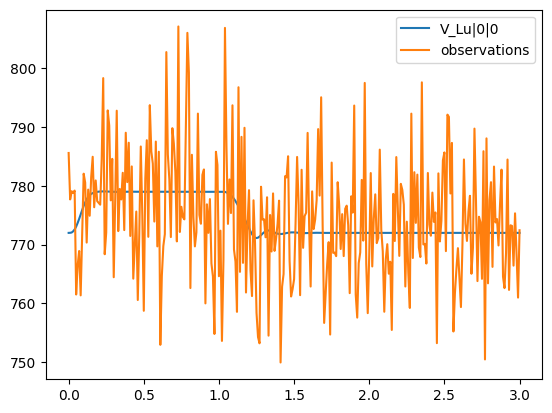

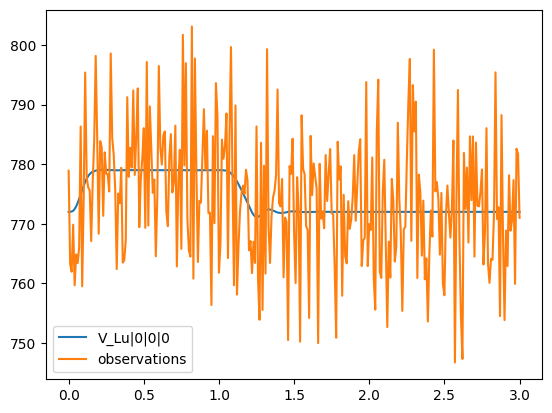

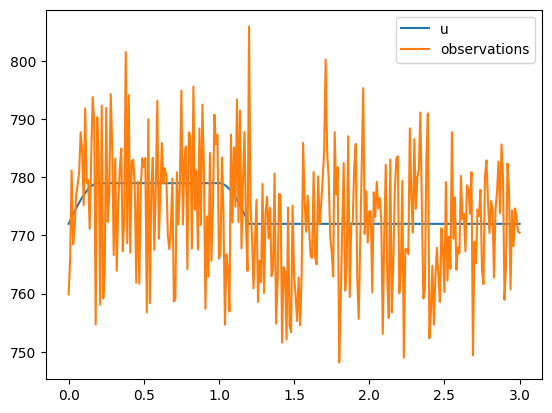

In [8]:

for key,results in runRes.items():
    obs = np.array(results)+ np.random.normal(0,10,results.shape)
    mpl.plot(np.array(t),np.array(results), label = key)
    mpl.plot(np.array(t),np.array(obs), label = 'observations')
    mpl.legend()
    mpl.show()


In [9]:
import functools as ft
import math as math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy
#import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [10]:
def lung(x):
    

SyntaxError: incomplete input (4161509244.py, line 2)

In [ ]:
## Implausibility measure
md=0
me=10
def Imp(obs,x,md,me):
    m = np.array(lung(x))
    I = math.sqrt(sum((obs-m)**2)/((me+md)*obs.shape[0]))
    return(I)

In [ ]:
#Subset Simulation for history matching
#algorithm we use to update samples, and we here consider Modified Metropolis
###modified metropolis
def modmetro(nc,ns,d,z,q):
    for j in range(1,nc+1):
        for m in range(1,ns+1):
            ### step 1
            for k in range(1,d+1):
                a = z[j-1,k-1,m-1]+np.random.randn(1)
                r = min(1, norm.pdf(a)/norm.pdf(z[j-1,k-1,m-1]))
                if np.random.rand(1)<r:
                    q[k-1]=a
                else:
                    q[k-1]=z[j-1,k-1,m-1]
            ###step 2 q belongs to F_L or not
            if Imp(obs=obs,x=q,me=me,md=md)<Ys[L]: ###responses
                z[j-1,:,m]=q
            else:
                z[j-1,:,m]=z[j-1,:,m-1]
    return(z)

def sus(obs,n,me,md):
    d = 2 #dimension of the input space first layer concludes 2 parameters?
    YF = 3 #critical threshold (gx>=YF)
    n = n #3000 #number of samples per level
    p = 0.1 #level probability
    nc = int(n*p) #number of Markov chains
    ns = int((1-p)/p) #number of states in each chain
    L = 0 # zero level
    Lmax = 100 # define the possible maximum of number of levels
    Xs = np.zeros((n,d,Lmax)) #samples for different levels
    xs = np.random.randn(n,d) # Monte Carlo samples(initial space filling samples)
    Xs[:,:,0] = xs ### samples for zero level
    nF = np.zeros(Lmax) # number of failure samples
    ys = np.zeros((Lmax,n)) # responses
    zs = np.zeros((nc,d,ns+1)) # seeds
    Ys = np.zeros(Lmax)# intermediate threshold
    qs = np.zeros(d)## potential next state in Markov chain?
    index = [0]
    for i in range(1, n+1):
        ys[0,i-1] = Imp(obs=obs,x=Xs[i-1,:,L],me=me,md=md) 
        if ys[0,i-1]<YF: # whether it falls in failure domain
            nF[0]=nF[0]+1
            index.append(i-1)       
    while (nF[L]/n)<p: # stopping criterion
        index = [0]
        L=L+1 # next conditional level is needed
        w = -ys[L-1,:]
        ind = sorted(range(len(w)), key=lambda k: w[k])# original index of descending responses
        ys[L-1,:] = ys[L-1,ind] #renumbered responses
        Xs[:,:, L-1] = Xs[ind,:,L-1] # renumbered samples
        Ys[L-1] = (ys[L-1,nc-1]+ys[L-1,nc])/2 #L^th intermediate threshold
        zs[:,:,0] = Xs[range(0,nc),:, L-1] # seeds of Markov chain
        zs = modmetro(nc,ns,d,z=zs,q=qs)###modified metropolis algorithm
        for j in range(1,nc+1):
            for m in range(1,ns+2):
                Xs[(j-1)*(ns+1)+m-1,:,L]=zs[j-1,:,m-1]### update L-th level samples
        zs = np.zeros((nc,d,ns+1))
        for i in range(1,n+1):
            ys[L, i-1] = Imp(obs=obs,x=Xs[i-1,:,L],me=me,md=md)
            if ys[L, i-1]<YF:
                nF[L]=nF[L]+1
                index.append(i-1)
    #index = np.where(np.array(xu)[:,0]==L)
    #xfin= np.array(xu)[index[0][:],1:]
    #return(xfin)
    Xfin = Xs[index[1:],:,L]
    return(Xfin)



In [ ]:
# history matching
N=1000
X=sus(obs=obs,n=N,me=me,md=md)#new particles obtained from SuS
y = np.zeros(X.shape[0])
for i in range(1,X.shape[0]+1):
    y[i-1] = Imp(obs=obs,x=X[i-1,:],me=me,md=md)

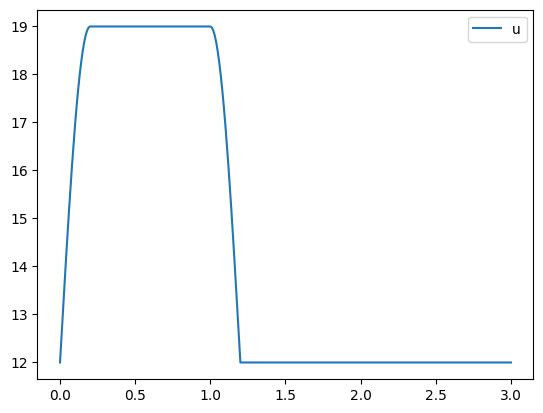

In [ ]:
# For the pressures of the cardiovascular model
for key,results in pressureRes.items():
    if ('Lu_' not in key) and ('|0' not in key):
        mpl.plot(np.array(t),np.array(results - 760), label = key)
mpl.legend()
mpl.show()

In [ ]:
###conditional U sampling
def conU(nc,ns,d,z,Y):
    na = int(0.1*nc)
    gamma = np.zeros(11)
    gamma[0] = 0.6
    q = np.zeros(2) ## potential next position
    ### compute mean and variance for each component
    mu = np.mean(z[:,:,0],axis=0)
    sigma0 = np.diag(np.cov(np.transpose(z[:,:,0])))
    ###permute randomly the seeds
    z[:,:,0] = z[random.sample(range(0,nc),nc),:,0]
    for iter in range(1,11):## nc/na=10 + 1
        acc = 0
        ###compute conditional variance
        sigma = np.multiply(gamma[iter-1],sigma0)
        sigma = [min(1,sigma[0]),min(1,sigma[1])]
        print(sigma)
        pou = [math.sqrt(1-sigma[0]**2),math.sqrt(1-sigma[1]**2)]
        cov = [math.sqrt(1-pou[0]**2),math.sqrt(1-pou[1]**2)]
        ### sample iter-th na chains
        for k in range((iter-1)*na+1,iter*na+1):##na chains
            #z[k-1,:,0]=seeds
            for t in range(1,ns+1):
                ### step 1 sample
                q = z[k-1,:,t]+multivariate_normal.rvs(mean=[z[k-1,0,t-1]*pou[0],z[k-1,1,t-1]*pou[1]],cov=np.diag(cov))
                ###step 2 q belongs to F_L or not
                if Imp(obs=obs,x=q,me=me,md=md)<Y: ###responses
                    z[k-1,:,t]=q
                    acc = acc + 1
                else:
                    z[k-1,:,t]=z[k-1,:,t-1]
        ### step 3 compute average acceptance rate
        a_iter = acc/(ns*na)
        ### step4 update gamma
        gamma[iter] = math.exp(math.log(gamma[iter-1])+(a_iter-0.44)/math.sqrt(iter))
        print(gamma[iter])
    return(z)

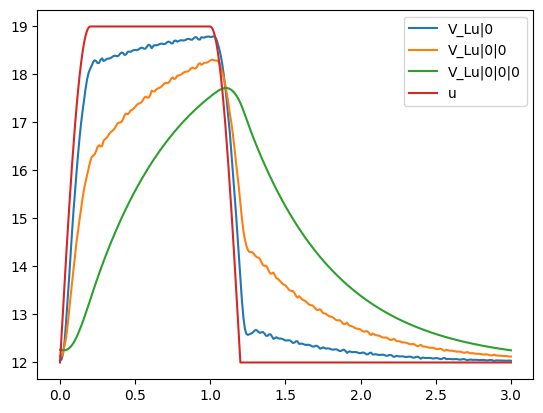

3.6047 -> Plotting completed!
5.174 -> Total run time!


In [ ]:
# For the pressures of the lung model
for key,results in pressureRes.items():
    if ('Lu_' in key) and ('|0' in key):
        mpl.plot(np.array(t),np.array(results - 760), label = key)
    if ('u' in key):
        mpl.plot(np.array(t),np.array(results - 760), label = key)
mpl.legend()
mpl.show()

print(str(np.round(time.time() - t1, 4)) + ' -> Plotting completed!')
print(str(np.round(time.time() - t0, 4)) + ' -> Total run time!')